In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
import bct
import nibabel as nib
import numpy as np
import os
import pandas as pd
import re
from scipy.stats import wilcoxon, ttest_rel, sem
import seaborn as sns
from statsmodels import robust

In [5]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
rcParams['figure.autolayout'] = True
mm2inches = 0.039371
single_column = 86*mm2inches
double_column = 180*mm2inches

In [6]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

In [7]:
outfolder = '/imaging/jb07/ZDHHC9/connectome_revisions/figures/'

In [8]:
def plot_adjacency_matrix(network, filename):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    rcParams['xtick.labelsize'] = 6 
    rcParams['ytick.labelsize'] = 6  

    ## Loading labels
    labels = pd.read_csv('/home/jb07/joe_python/GitHub/ZDHHC9_connectome/DK_labels.txt', header=None)[0].values

    plt.figure(figsize=(double_column, double_column), dpi=300)
    im = plt.imshow(network, 
               cmap='afmhot',
               interpolation='none',
               vmin=0,
               vmax=1)
    ax = plt.gca()
    ax.set_yticks(np.arange(0,network.shape[0]))
    ax.set_yticklabels(labels)
    ax.set_xticks(np.arange(0,network.shape[0]))
    ax.set_xticklabels(labels, rotation=90)
    ax.grid('off')
    
    rcParams['xtick.labelsize'] = 9
    rcParams['ytick.labelsize'] = 9  
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.ax.yaxis.set_label_position('right')
    plt.tight_layout(pad=0, w_pad=1, h_pad=0)
    plt.savefig(filename, dpi=600)
    plt.show()

In [9]:
def load_data(folder, model, threshold, weight, subject): 
    import numpy as np
    
    if weight == '_FA':
        weight_switch = str(0)
    elif weight == '_RD':
        weight_switch = str(1)
    elif weight == '_GFA':
        weight_switch = str(2)
        
    matrix = folder + '_subject_id_' + subject + '/_model_' + model + '/_threshold_' + threshold + '/calc_matrix/mapflow/_calc_matrix' + weight_switch + '/' + subject + weight + '_matrix.txt'
    matrix = np.loadtxt(matrix)
    
    # Exclude label entries 
    entries_to_exclude = [1, 2, 3, 4, 10, 11, 15, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
    matrix = np.delete(matrix,entries_to_exclude, axis=0)
    matrix = np.delete(matrix,entries_to_exclude, axis=1)
    
    # Removing NaN values
    matrix[np.isnan(matrix)] = 0
    
    return matrix

In [10]:
folder = '/imaging/jb07/ZDHHC9/connectome_revisions/connectome/'

In [11]:
subject_list = sorted([subject.split('_')[-1] for subject in os.listdir(folder) if re.search('subject', subject)])

## Plotting overview matrices

In [199]:
control_networks = np.rollaxis(np.asarray([load_data(folder, 'CSD', str(10), '_FA', subject) for subject in subject_list if re.search('c', subject)]), 0, 3)
ZDHHC9_networks = np.rollaxis(np.asarray([load_data(folder, 'CSD', str(10), '_FA', subject) for subject in subject_list if re.search('z', subject)]), 0, 3)

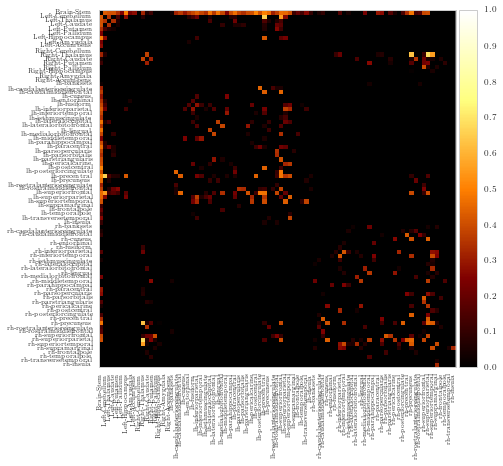

In [198]:
plot_adjacency_matrix(np.mean(ZDHHC9_networks, axis=2), outfolder + 'ZDHHC9_adjmat.png')

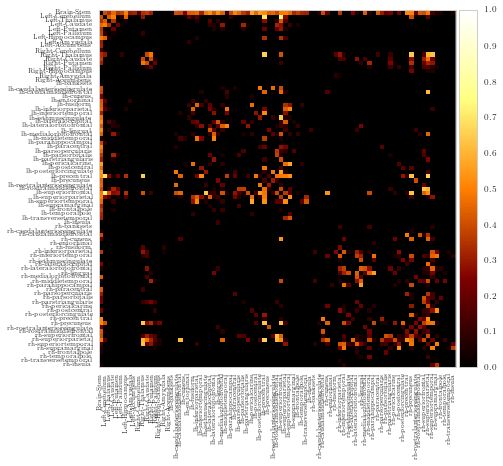

In [194]:
plot_adjacency_matrix(np.mean(control_networks, axis=2), outfolder + 'control_adjmat.png')

In [32]:
networks = np.rollaxis(np.asarray([load_data(folder, 'CSD', str('0'), '_FA', subject) for subject in subject_list]), 0, 3)

Creating files for visualization with BrainNet Viewer

In [514]:
np.savetxt(outfolder + 'control_mean.txt', np.mean(networks[...,0:7], axis=2))
np.savetxt(outfolder + 'ZDHHC9_mean.txt', np.mean(networks[...,7:14], axis=2))

In [721]:
np.unique(roi_data)[1:2]

array([2], dtype=int32)

In [8]:
roi_file = '/imaging/jb07/ZDHHC9/connectome_revisions/connectome/FreeSurfer/c1/parcellation/aparc.nii.gz'

roi_data = nib.load(roi_file).get_data()
roi_affine = nib.load(roi_file).affine
new_atlas = np.zeros(shape=[roi_data.shape[0], roi_data.shape[1], roi_data.shape[2], len(np.unique(roi_data)[1:2])])
counter = 0

for label in np.unique(roi_data)[1:2]:
    atlas_volume = roi_data.copy()
    atlas_volume[atlas_volume != label] = 0
    atlas_volume[atlas_volume == label] = 1
    new_atlas[..., counter] = atlas_volume
    counter += 1
    
nib.save(nib.Nifti1Image(new_atlas, roi_affine), outfolder + 'new_atlas.nii.gz')

In [16]:
coordinates = pd.read_csv('/imaging/jb07/ZDHHC9/connectome_revisions/figures/coordinates.csv', header=None, sep=' ').values

In [40]:
degrees[15:].shape

(70,)

In [50]:
degrees = bct.degrees_und(np.mean(networks[...,0:7], axis=2))
pd.DataFrame({'x':coordinates[:,0], 'y':coordinates[:, 1], 'z':coordinates[:, 2], 'size':degrees[15:], 'colour':degrees[15:]}).to_csv('/imaging/jb07/ZDHHC9/connectome_revisions/figures/test.node', sep='\t', header=None)

In [48]:
mean_network = np.mean(networks[...,0:7], axis=2)
mean_network = mean_network[15:, :]
mean_network = mean_network[:, 15:]
np.savetxt('/imaging/jb07/ZDHHC9/connectome_revisions/figures/mean_control.edge', mean_network)

In [49]:
mean_network.shape

(70, 70)

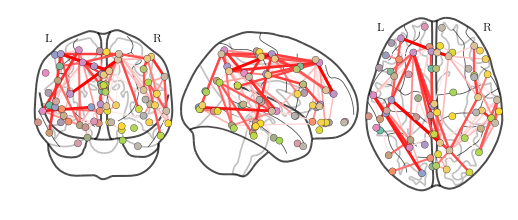

In [707]:
nilearn.plotting.plot_connectome(mean_network, coordinates)

## Comparison of edge weight by region

In [46]:
d = []
threshold_range = np.arange(0,100,10)

for subject in subject_list:
    for threshold in threshold_range:
        
        # Loading the adjacency matrix
        network = load_data(folder, 'CSD', str(threshold), '_FA', subject)
        
        # Getting the labels for the matrix
        labels = pd.read_csv('/home/jb07/joe_python/GitHub/ZDHHC9_connectome/DK_labels.txt', header=None)[0].values
        
        subcortical_labels = [np.where(labels == label)[0][0] for label in labels if re.search('(Left|Right)', label)]
        lh_labels = [np.where(labels == label)[0][0] for label in labels if re.search('lh', label)]
        rh_labels = [np.where(labels == label)[0][0] for label in labels if re.search('rh', label)]

        mean_connection_strength = list()
        
        # Selecting subcortical, left and right cortical, and cortical interhemispheric connections
        for labels in [(subcortical_labels, subcortical_labels), (lh_labels, lh_labels), (rh_labels, rh_labels), (lh_labels, rh_labels)]:
            subconnections = network.copy()
            subconnections = subconnections[labels[0], ...]
            subconnections = subconnections[..., labels[1]]
            mean_connection_strength.append(np.mean(subconnections))
        
        # Setting group variable
        group = 'ZDHHC9' if re.search('z', subject) else 'control'
        
        d.append({'ID': subject,
                  'group': group,
                 'threshold': threshold,
                 'subcortical': mean_connection_strength[0],
                 'lh': mean_connection_strength[1],
                 'rh': mean_connection_strength[2],
                 'interhemispheric':mean_connection_strength[3]})
        
df = pd.DataFrame(d)

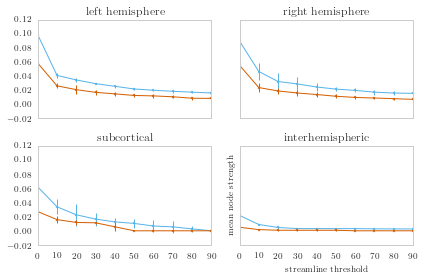

In [23]:
fig = plt.figure(figsize=(single_column, single_column), dpi=600)
fig,axs = plt.subplots(2,2, sharex=True, sharey=True)
ordering = [[1,0],[0,0], [0,1], [1,1]]
titles = ['subcortical', 'left hemisphere', 'right hemisphere', 'interhemispheric']
counter = 0

for measure in ['subcortical', 'lh', 'rh', 'interhemispheric']:
    for group in ['control', 'ZDHHC9']:

        copy_df = df.copy()
        copy_df = copy_df[df['group'] == group]
        median = copy_df.groupby('threshold').median()[measure].values
        mad = copy_df.groupby('threshold').agg(robust.mad)[measure].values
        colour = '#56B4E9' if group == 'control' else '#D55E00'
        marker = 'o' if measure == 'clustering_coefficient' else 'D'
        
        axs[ordering[counter][0], ordering[counter][1]].errorbar(x = threshold_range,
                     y = median,
                     yerr = mad,
                     marker = marker,
                     markersize = 2,
                     color=colour,
                     linestyle='solid',
                     linewidth=1)
        axs[ordering[counter][0], ordering[counter][1]].set_title(titles[counter])
    counter += 1

    if measure == 'subcortical':
        plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')
        plt.xlabel('streamline threshold')
        plt.ylabel('mean node strength')
        
plt.savefig(outfolder + '/regional_node_strength.png', dpi=600)
plt.show()

In [26]:
for measure in ['subcortical', 'lh', 'rh', 'interhemispheric']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]
    print measure + '\n'
    print('ZDHHC9 AUC: mean=' + str(round(np.mean(ZDHHC9_area), 2)) +
         '; SE=' + str(round(sem(ZDHHC9_area), 3)))
    print('ZDHHC9 AUC: median=' + str(round(np.median(ZDHHC9_area), 2)) +
         '; mad=' + str(round(robust.mad(ZDHHC9_area), 3)))
    print('control AUC: mean=' + str(round(np.mean(control_area), 2)) +
         '; SE=' + str(round(sem(control_area), 3)))
    print('control AUC: median=' + str(round(np.median(control_area), 2)) +
         '; mad=' + str(round(robust.mad(control_area), 3)))
    print('Wilcoxon: W=' + 
    str(wilcoxon(control_area, ZDHHC9_area)[0]) + '; p=' +
    str(round(wilcoxon(control_area, ZDHHC9_area)[1], 3)))
    print('Paired t-test: t(' + str(len(control_area) -1) + ')=' + 
    str(round(ttest_rel(control_area, ZDHHC9_area)[0], 2)) + '; p=' +
    str(round(ttest_rel(control_area, ZDHHC9_area)[1], 3)) + ' corrected-p=' + 
    str(round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)) + '\n')

subcortical

ZDHHC9 AUC: mean=0.08; SE=0.011
ZDHHC9 AUC: median=0.07; mad=0.033
control AUC: mean=0.18; SE=0.018
control AUC: median=0.18; mad=0.062
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=5.32; p=0.002 corrected-p=0.007

lh

ZDHHC9 AUC: mean=0.19; SE=0.012
ZDHHC9 AUC: median=0.18; mad=0.034
control AUC: mean=0.33; SE=0.012
control AUC: median=0.31; mad=0.014
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=11.68; p=0.0 corrected-p=0.0

rh

ZDHHC9 AUC: mean=0.16; SE=0.01
ZDHHC9 AUC: median=0.18; mad=0.015
control AUC: mean=0.3; SE=0.022
control AUC: median=0.31; mad=0.094
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=7.02; p=0.0 corrected-p=0.002

interhemispheric

ZDHHC9 AUC: mean=0.01; SE=0.004
ZDHHC9 AUC: median=0.01; mad=0.008
control AUC: mean=0.06; SE=0.005
control AUC: median=0.06; mad=0.012
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=8.76; p=0.0 corrected-p=0.0



Creating a $Latex$ version of the table

In [48]:
d = []
for measure in ['subcortical', 'lh', 'rh', 'interhemispheric']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]

    d.append({
    'measure': measure,
    'ZDHHC9_mean': round(np.mean(ZDHHC9_area), 2),
    'ZDHHC9_SE': round(sem(ZDHHC9_area), 3),
    'ZDHHC9_med': round(np.median(ZDHHC9_area), 2),
    'ZDHHC9_mad': round(robust.mad(ZDHHC9_area), 3),
    'control_mean': round(np.mean(control_area), 2),
    'control_SE': round(sem(control_area), 3),
    'control_med': round(np.median(control_area), 2),
    'control_mad': round(robust.mad(control_area), 3),
    'Wilcoxon_stat': round(wilcoxon(control_area, ZDHHC9_area)[0], 2),
    'Wilcoxon_p': round(wilcoxon(control_area, ZDHHC9_area)[1], 3),
    'ttest stat': round(ttest_rel(control_area, ZDHHC9_area)[0], 2),
    'ttest p': round(ttest_rel(control_area, ZDHHC9_area)[1], 3),
    'ttest corrp': round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)
    })
    
result_df = pd.DataFrame(d)
print(result_df[['measure', 'ZDHHC9_mean', 'ZDHHC9_SE', 'ZDHHC9_med', 'ZDHHC9_mad', 'control_mean', 'control_SE', 'control_med', 'control_mad', 'Wilcoxon_stat', 'Wilcoxon_p', 'ttest stat', 'ttest p', 'ttest corrp']].to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
          measure &  ZDHHC9\_mean &  ZDHHC9\_SE &  ZDHHC9\_med &  ZDHHC9\_mad &  control\_mean &  control\_SE &  control\_med &  control\_mad &  Wilcoxon\_stat &  Wilcoxon\_p &  ttest stat &  ttest p &  ttest corrp \\
\midrule
      subcortical &         0.08 &      0.011 &        0.07 &       0.033 &          0.18 &       0.018 &         0.18 &        0.062 &              0 &       0.018 &        5.32 &    0.002 &        0.007 \\
               lh &         0.19 &      0.012 &        0.18 &       0.034 &          0.33 &       0.012 &         0.31 &        0.014 &              0 &       0.018 &       11.68 &    0.000 &        0.000 \\
               rh &         0.16 &      0.010 &        0.18 &       0.015 &          0.30 &       0.022 &         0.31 &        0.094 &              0 &       0.018 &        7.02 &    0.000 &        0.002 \\
 interhemispheric &         0.01 &      0.004 &        0.01 &       0.008 &          0.06 &       0.005 &   

## Graph theory analysis

### 1. Mean node degree & strength

Because the node degree has a large influence on all other graph measures, differences in mean node degree are investigated first. The following section calculates the average node degree in the network for participants in the *ZDHHC9* and control group over a range of streamline thresholds. The groups are compared on the area under the curve of mean node degree across thresholds. 

In [49]:
threshold_range = np.arange(0,100,10)
d = []

for threshold in threshold_range:
    for subject in subject_list:
        network = load_data(folder, 'CSD', str(threshold), '_FA', subject)
        network[np.isnan(network)] = 0 # removing NaN
        
        # Calculating graph metrics
        mean_degree = np.mean(bct.degrees_und(network))
        mean_strength = np.mean(bct.strengths_und(network))
        
        # Setting group variable
        group = 'ZDHHC9' if re.search('z', subject) else 'control'

        # Collecting the data
        d.append({'ID':subject, 
                  'threshold': threshold,
                  'group': group,
                  'mean_degree': mean_degree,
                  'mean_strength': mean_strength})
        
df = pd.DataFrame(d)

In [51]:
for measure in ['mean_degree', 'mean_strength']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]
    print measure + '\n'
    print('ZDHHC9 AUC: mean=' + str(round(np.mean(ZDHHC9_area), 2)) +
         '; SE=' + str(round(sem(ZDHHC9_area), 3)))
    print('ZDHHC9 AUC: median=' + str(round(np.median(ZDHHC9_area), 2)) +
         '; mad=' + str(round(robust.mad(ZDHHC9_area), 3)))
    print('control AUC: mean=' + str(round(np.mean(control_area), 2)) +
         '; SE=' + str(round(sem(control_area), 3)))
    print('control AUC: median=' + str(round(np.median(control_area), 2)) +
         '; mad=' + str(round(robust.mad(control_area), 3)))
    print('Wilcoxon: W=' + 
    str(wilcoxon(control_area, ZDHHC9_area)[0]) + '; p=' +
    str(round(wilcoxon(control_area, ZDHHC9_area)[1], 3)))
    print('Paired t-test: t(' + str(len(control_area) -1) + ')=' + 
    str(round(ttest_rel(control_area, ZDHHC9_area)[0], 2)) + '; p=' +
    str(round(ttest_rel(control_area, ZDHHC9_area)[1], 3)) + ' corrected-p=' + 
    str(round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)) + '\n')

mean_degree

ZDHHC9 AUC: mean=22.23; SE=0.921
ZDHHC9 AUC: median=21.98; mad=2.163
control AUC: mean=33.18; SE=1.056
control AUC: median=32.94; mad=3.384
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=10.14; p=0.0 corrected-p=0.0

mean_strength

ZDHHC9 AUC: mean=9.57; SE=0.487
ZDHHC9 AUC: median=9.86; mad=1.648
control AUC: mean=16.34; SE=0.645
control AUC: median=15.64; mad=1.785
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=13.08; p=0.0 corrected-p=0.0



In [50]:
d = []
for measure in ['mean_degree', 'mean_strength']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]

    d.append({
    'measure': measure,
    'ZDHHC9_mean': round(np.mean(ZDHHC9_area), 2),
    'ZDHHC9_SE': round(sem(ZDHHC9_area), 3),
    'ZDHHC9_med': round(np.median(ZDHHC9_area), 2),
    'ZDHHC9_mad': round(robust.mad(ZDHHC9_area), 3),
    'control_mean': round(np.mean(control_area), 2),
    'control_SE': round(sem(control_area), 3),
    'control_med': round(np.median(control_area), 2),
    'control_mad': round(robust.mad(control_area), 3),
    'Wilcoxon_stat': round(wilcoxon(control_area, ZDHHC9_area)[0], 2),
    'Wilcoxon_p': round(wilcoxon(control_area, ZDHHC9_area)[1], 3),
    'ttest stat': round(ttest_rel(control_area, ZDHHC9_area)[0], 2),
    'ttest p': round(ttest_rel(control_area, ZDHHC9_area)[1], 3),
    'ttest corrp': round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)
    })
    
result_df = pd.DataFrame(d)
print(result_df[['measure', 'ZDHHC9_mean', 'ZDHHC9_SE', 'ZDHHC9_med', 'ZDHHC9_mad', 'control_mean', 'control_SE', 'control_med', 'control_mad', 'Wilcoxon_stat', 'Wilcoxon_p', 'ttest stat', 'ttest p', 'ttest corrp']].to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
       measure &  ZDHHC9\_mean &  ZDHHC9\_SE &  ZDHHC9\_med &  ZDHHC9\_mad &  control\_mean &  control\_SE &  control\_med &  control\_mad &  Wilcoxon\_stat &  Wilcoxon\_p &  ttest stat &  ttest p &  ttest corrp \\
\midrule
   mean\_degree &        22.23 &      0.921 &       21.98 &       2.163 &         33.18 &       1.056 &        32.94 &        3.384 &              0 &       0.018 &       10.14 &        0 &            0 \\
 mean\_strength &         9.57 &      0.487 &        9.86 &       1.648 &         16.34 &       0.645 &        15.64 &        1.785 &              0 &       0.018 &       13.08 &        0 &            0 \\
\bottomrule
\end{tabular}



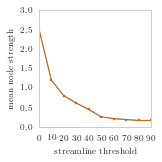

In [58]:
for measure in ['mean_degree']:
    fig = plt.figure(figsize=(double_column/3, double_column/3), dpi=600)

    for group in ['control', 'ZDHHC9']:

        copy_df = df.copy()
        copy_df = copy_df[df['group'] == group]
        median = copy_df.groupby('threshold').median()[measure].values
        mad = copy_df.groupby('threshold').agg(robust.mad)[measure].values
        colour = '#56B4E9' if group == 'control' else '#D55E00'
        marker = 'o' if measure == 'clustering_coefficient' else 'D'

        plt.errorbar(x = threshold_range,
                     y = median,
                     yerr = mad,
                     marker = marker,
                     markersize = 2,
                     color=colour,
                     linestyle='solid',
                     linewidth=1)


    #plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')
    plt.xlabel('streamline threshold')
    plt.ylabel('mean node strength')
    plt.savefig(outfolder + '/mean_node_strength.png', dpi=600)
    plt.show()

### 3. Clustering coefficient & Global efficiency
The mean node degree analysis indicated significant differences between the groups. Differences in $D_{G}$ may influence other graph measures. Consensus thresholding is applied to equalize the number of connections in both groups

In [52]:
def consensus_thresholding(in_matrices, percentage_threshold):
    # ===============================================================#
    # Consensus thresholding of connectivity matrices 
    # for method see: http://www.ncbi.nlm.nih.gov/pubmed/23296185
    # ===============================================================#
    """
    inputs:
    in_matrices: numpy array with connectivity matrices (dimensions: ROIs x ROIs x participants)
    percentage_threshold: ratio of connections to be retained, e.g. 0.6

    outputs:
    matrices only retained connections that occured in the percentage threshold of participants
    """

    import bct
    import numpy as np
    
    connection_consensus = np.sum(np.asarray(in_matrices > 0), 2).astype('float64')/in_matrices.shape[2]
    connection_consensus = bct.binarize(bct.threshold_absolute(W=connection_consensus, thr=percentage_threshold))
    consensus_matrices = in_matrices * np.reshape(np.repeat(connection_consensus,in_matrices.shape[2]), newshape=in_matrices.shape)
    
    return consensus_matrices

In [53]:
d = []

for threshold in np.arange(0,100,10):
    
    # Consensus thresholding to equalise the graph density between groups
    networks = np.rollaxis(np.asarray([load_data(folder, 'CSD', str(threshold), '_FA', subject) for subject in subject_list]), 0, 3)
    networks = consensus_thresholding(networks, 1)
    
    # Calculating graph measures in the matched networks
    for i in range(0,len(subject_list)):
        subject = subject_list[i]

        # Calculating graph metrics
        mean_degree = np.mean(bct.degrees_und(networks[...,i]))
        clustering_coefficient = np.mean(bct.clustering_coef_wu(networks[...,i]))
        global_efficiency = bct.charpath(bct.distance_wei(bct.weight_conversion(networks[...,i], 'lengths'))[0])[1]

        # Setting group variable
        group = 'ZDHHC9' if re.search('z', subject) else 'control'

        # Collecting the data
        d.append({'ID':subject, 
                  'group': group,
                  'threshold': threshold,
                  'mean_degree': mean_degree,
                  'clustering_coefficient': clustering_coefficient,
                  'global_efficiency': global_efficiency})

df = pd.DataFrame(d)

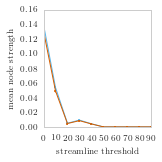

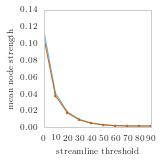

In [54]:
for measure in ['clustering_coefficient', 'global_efficiency']:
    fig = plt.figure(figsize=(double_column/3, double_column/3), dpi=600)

    for group in ['control', 'ZDHHC9']:

        copy_df = df.copy()
        copy_df = copy_df[df['group'] == group]
        median = copy_df.groupby('threshold').median()[measure].values
        mad = copy_df.groupby('threshold').agg(robust.mad)[measure].values
        colour = '#56B4E9' if group == 'control' else '#D55E00'
        marker = 'o' if measure == 'clustering_coefficient' else 'D'

        plt.errorbar(x = threshold_range,
                     y = median,
                     yerr = mad,
                     marker = marker,
                     markersize = 2,
                     color=colour,
                     linestyle='solid',
                     linewidth=1)


    #plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')
    plt.xlabel('streamline threshold')
    plt.ylabel('mean node strength')
    plt.savefig(outfolder + '/mean_node_strength.png', dpi=600)
    plt.show()

In [55]:
for measure in ['clustering_coefficient', 'global_efficiency']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]
    print measure + '\n'
    print('ZDHHC9 AUC: mean=' + str(round(np.mean(ZDHHC9_area), 2)) +
         '; SE=' + str(round(sem(ZDHHC9_area), 3)))
    print('ZDHHC9 AUC: median=' + str(round(np.median(ZDHHC9_area), 2)) +
         '; mad=' + str(round(robust.mad(ZDHHC9_area), 3)))
    print('control AUC: mean=' + str(round(np.mean(control_area), 2)) +
         '; SE=' + str(round(sem(control_area), 3)))
    print('control AUC: median=' + str(round(np.median(control_area), 2)) +
         '; mad=' + str(round(robust.mad(control_area), 3)))
    print('Wilcoxon: W=' + 
    str(wilcoxon(control_area, ZDHHC9_area)[0]) + '; p=' +
    str(round(wilcoxon(control_area, ZDHHC9_area)[1], 3)))
    print('Paired t-test: t(' + str(len(control_area) -1) + ')=' + 
    str(round(ttest_rel(control_area, ZDHHC9_area)[0], 2)) + '; p=' +
    str(round(ttest_rel(control_area, ZDHHC9_area)[1], 3)) + ' corrected-p=' + 
    str(round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)) + '\n')

clustering_coefficient

ZDHHC9 AUC: mean=0.2; SE=0.003
ZDHHC9 AUC: median=0.2; mad=0.007
control AUC: mean=0.21; SE=0.003
control AUC: median=0.21; mad=0.006
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=5.91; p=0.001 corrected-p=0.004

global_efficiency

ZDHHC9 AUC: mean=0.18; SE=0.003
ZDHHC9 AUC: median=0.18; mad=0.005
control AUC: mean=0.2; SE=0.002
control AUC: median=0.2; mad=0.009
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=5.81; p=0.001 corrected-p=0.005



In [59]:
d = []
for measure in ['clustering_coefficient', 'global_efficiency']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]

    d.append({
    'measure': measure,
    'ZDHHC9_mean': round(np.mean(ZDHHC9_area), 2),
    'ZDHHC9_SE': round(sem(ZDHHC9_area), 3),
    'ZDHHC9_med': round(np.median(ZDHHC9_area), 2),
    'ZDHHC9_mad': round(robust.mad(ZDHHC9_area), 3),
    'control_mean': round(np.mean(control_area), 2),
    'control_SE': round(sem(control_area), 3),
    'control_med': round(np.median(control_area), 2),
    'control_mad': round(robust.mad(control_area), 3),
    'Wilcoxon_stat': round(wilcoxon(control_area, ZDHHC9_area)[0], 2),
    'Wilcoxon_p': round(wilcoxon(control_area, ZDHHC9_area)[1], 3),
    'ttest stat': round(ttest_rel(control_area, ZDHHC9_area)[0], 2),
    'ttest p': round(ttest_rel(control_area, ZDHHC9_area)[1], 3),
    'ttest corrp': round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)
    })
    
result_df = pd.DataFrame(d)
print(result_df[['measure', 'ZDHHC9_mean', 'ZDHHC9_SE', 'ZDHHC9_med', 'ZDHHC9_mad', 'control_mean', 'control_SE', 'control_med', 'control_mad', 'Wilcoxon_stat', 'Wilcoxon_p', 'ttest stat', 'ttest p', 'ttest corrp']].to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
                measure &  ZDHHC9\_mean &  ZDHHC9\_SE &  ZDHHC9\_med &  ZDHHC9\_mad &  control\_mean &  control\_SE &  control\_med &  control\_mad &  Wilcoxon\_stat &  Wilcoxon\_p &  ttest stat &  ttest p &  ttest corrp \\
\midrule
 clustering\_coefficient &         0.20 &      0.003 &        0.20 &       0.007 &          0.21 &       0.003 &         0.21 &        0.006 &              0 &       0.018 &        5.91 &    0.001 &        0.004 \\
      global\_efficiency &         0.18 &      0.003 &        0.18 &       0.005 &          0.20 &       0.002 &         0.20 &        0.009 &              0 &       0.018 &        5.81 &    0.001 &        0.005 \\
\bottomrule
\end{tabular}



## Comparison of topographic variation in graph metrics

In [86]:
d = []

for threshold in np.arange(0,100,10):
    
    # Consensus thresholding to equalise the graph density between groups
    networks = np.rollaxis(np.asarray([load_data(folder, 'CSD', str(threshold), '_FA', subject) for subject in subject_list]), 0, 3)
    
    # Calculating graph measures in the matched networks
    for i in range(0,len(subject_list)):
        subject = subject_list[i]

        # Calculating graph metrics
        degrees = bct.degrees_und(networks[...,i])
        
        # Setting group variable
        group = 'ZDHHC9' if re.search('z', subject) else 'control'

        # Collecting the data
        d.append({'ID':subject, 
                  'group': group,
                  'threshold': threshold,
                  'mean_degrees': degrees})

df = pd.DataFrame(d)

,ID,group,mean_degrees,threshold
0,c1,control,"[79.0, 13.0, 12.0, 14.0, 11.0, 3.0, 19.0, 7.0,...",0
1,c2,control,"[76.0, 11.0, 8.0, 14.0, 7.0, 1.0, 17.0, 6.0, 2...",0
2,c3,control,"[78.0, 13.0, 3.0, 11.0, 13.0, 4.0, 23.0, 4.0, ...",0
3,c5,control,"[74.0, 13.0, 8.0, 9.0, 14.0, 6.0, 14.0, 6.0, 2...",0
4,c6,control,"[75.0, 17.0, 10.0, 9.0, 15.0, 3.0, 10.0, 5.0, ...",0
5,c7,control,"[80.0, 13.0, 13.0, 11.0, 14.0, 5.0, 19.0, 5.0,...",0
6,c8,control,"[81.0, 12.0, 4.0, 7.0, 12.0, 2.0, 16.0, 4.0, 1...",0
7,z1,ZDHHC9,"[73.0, 13.0, 13.0, 8.0, 7.0, 1.0, 16.0, 6.0, 1...",0
8,z2,ZDHHC9,"[70.0, 6.0, 10.0, 4.0, 7.0, 3.0, 10.0, 3.0, 1....",0
9,z3,ZDHHC9,"[68.0, 11.0, 8.0, 9.0, 12.0, 4.0, 16.0, 2.0, 2...",0
